This notebook discusses how to measure the size of all discharge events. This notebook should be used for bege, coax and ppc detector types. 

**Contents:**

**Section 1:**
This section discusses the cuts requried to isolate all discharge events, this has been discussed in detail in the notebook named `CUTS.ipynb`

**Section 2**

This section calculates the magnitude of all discharge events. 

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

## Section 1

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T054554Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "bege"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

In [6]:
tb_data_dict = {}  
wfs_all_dict = {}  

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]
    
    min_values = []
    
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

**Initial cuts**

Discharges typically have a smaller minimum value than calibration events and hence it is easier to remove baselines and testing data.

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    min_z_scores = zscore(min_values)
    
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    for i, z_score in enumerate(min_z_scores):
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1 
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

Introducing a parameter which will tell how many waveforms were correctly removed.

Another cut but now for the maximal value 

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    for i, z_score in enumerate(max_z_scores):
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [14]:
threshold =1 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1  
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            #plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform

        # Customize plot
        #plt.xlabel('Time ($\mu s$)')
        #plt.ylabel('Voltage (mV)')
        #plt.title(f'Skipped events in detector {j} which is a {test}')
        #plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Skipped waveforms for detector ch1107202: [418]
Percentage of discharges present: 0.07077140835102247%
Skipped waveforms for detector ch1110402: [76, 683, 725]
Percentage of discharges present: 0.2123142250530785%
Skipped waveforms for detector ch1110403: [238, 683, 1334]
Percentage of discharges present: 0.2123142250530785%
This detector ch1112005 doesn't have any discharges
Skipped waveforms for detector ch1113600: [661, 885, 1026, 1197]
Percentage of discharges present: 0.283085633404101%
Skipped waveforms for detector ch1113601: [193, 661, 1026, 1197, 1202]
Percentage of discharges present: 0.35385704175513455%
Skipped waveforms for detector ch1113602: [193, 876]
Percentage of discharges present: 0.14154281670205604%
Skipped waveforms for detector ch1113603: [595, 598, 803, 1305, 1308]
Percentage of discharges present: 0.35385704175513455%
Skipped waveforms for detector ch1113604: [595]
Percentage of discharges present: 0.07077140835102247%
This detector ch1113605 doesn't have any 

## Section 2

microdischarge


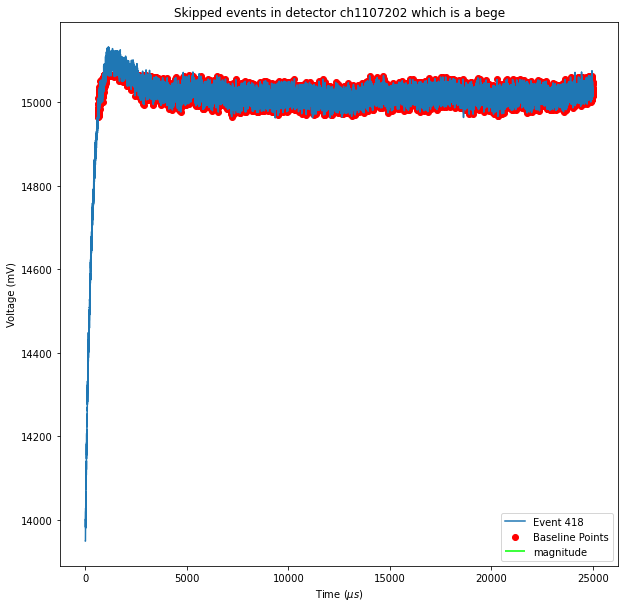

discharge


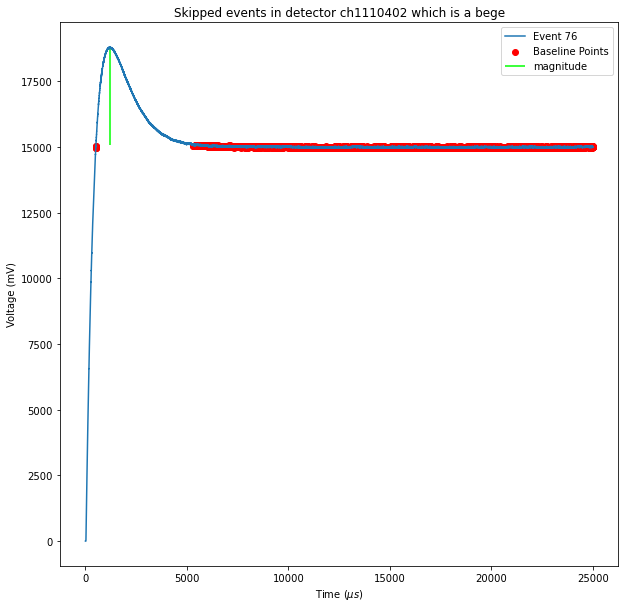

microdischarge


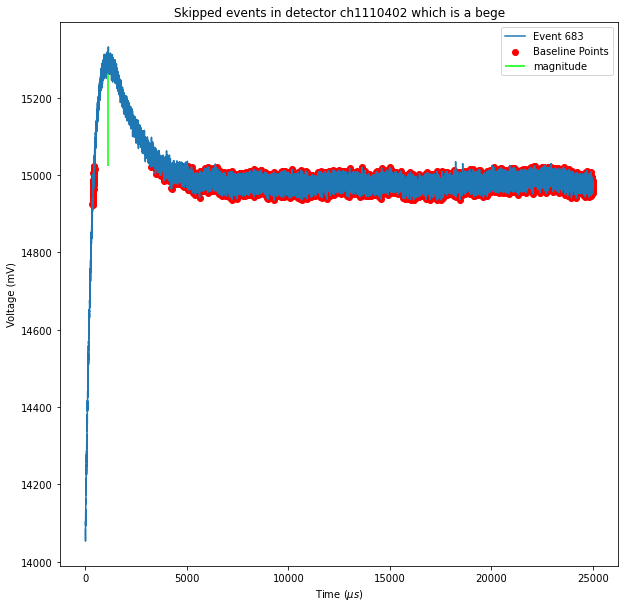

discharge


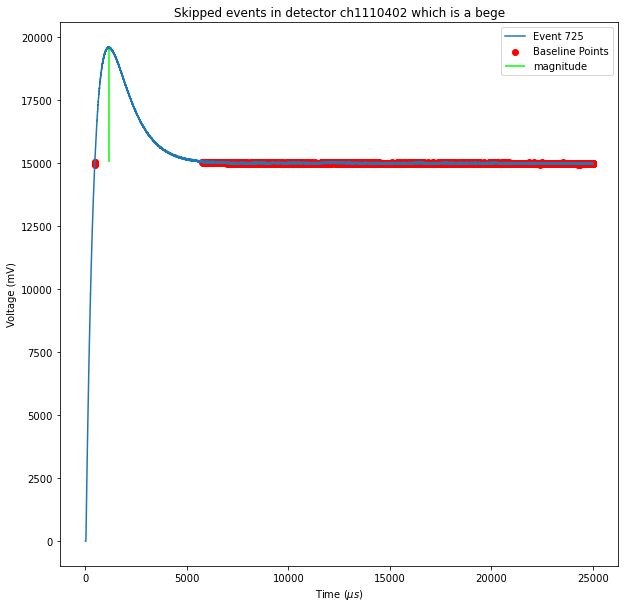

microdischarge


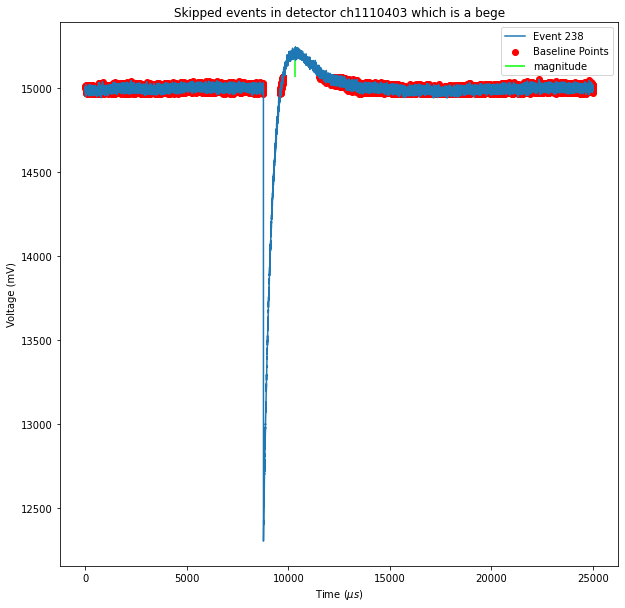

discharge


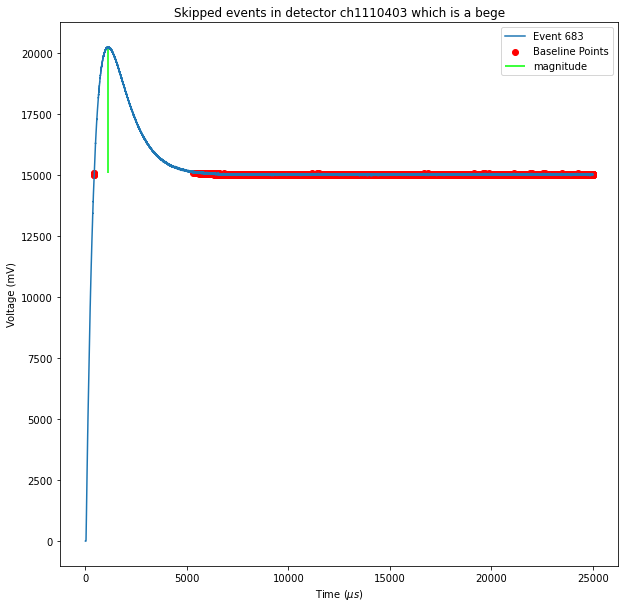

microdischarge


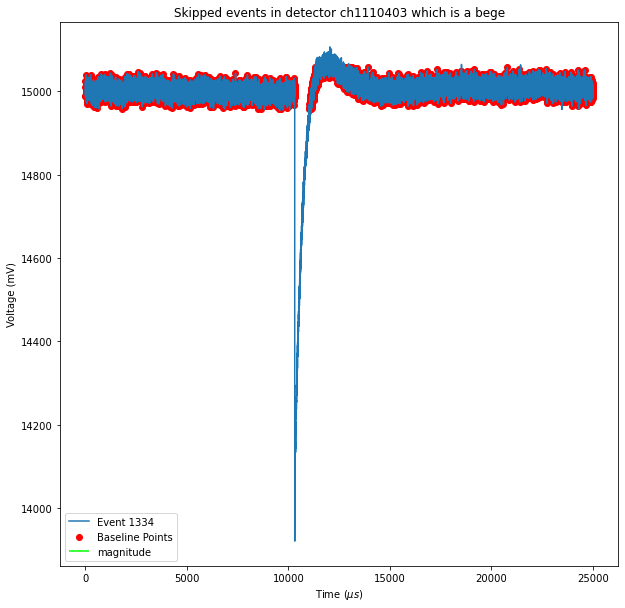

microdischarge


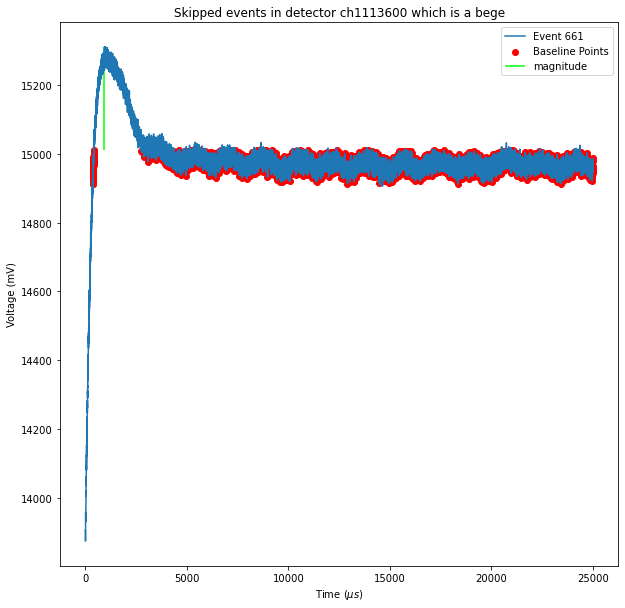

microdischarge


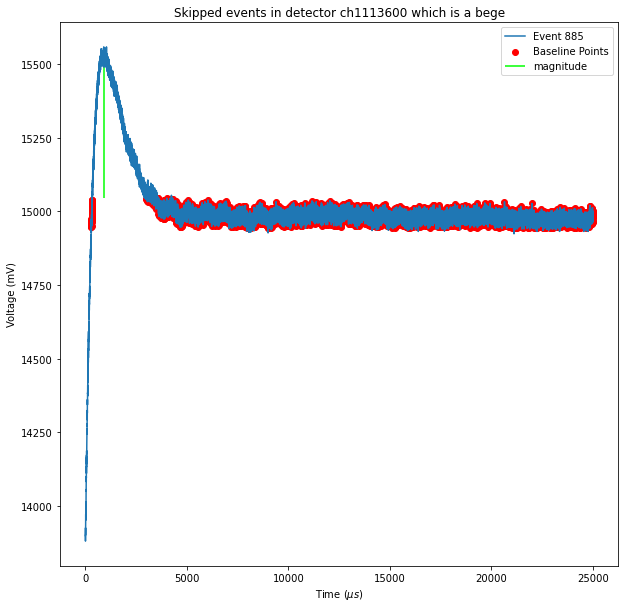

microdischarge


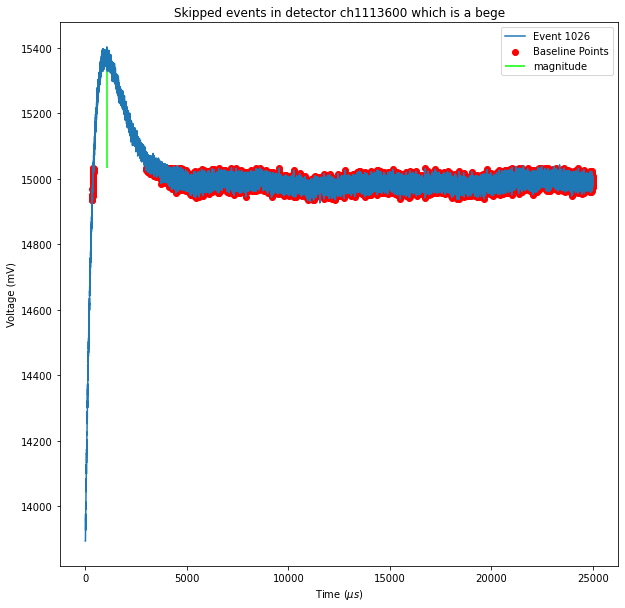

microdischarge


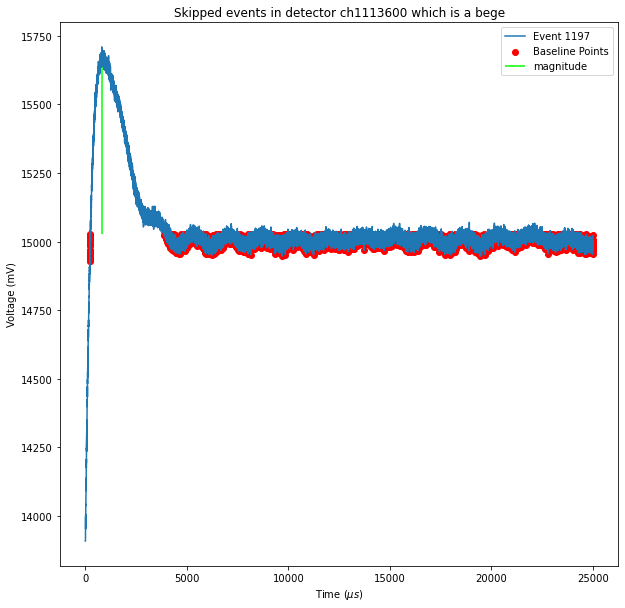

microdischarge


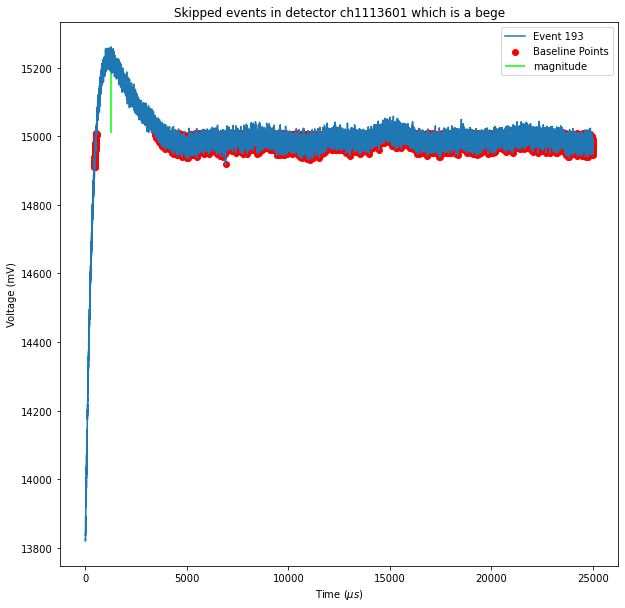

discharge


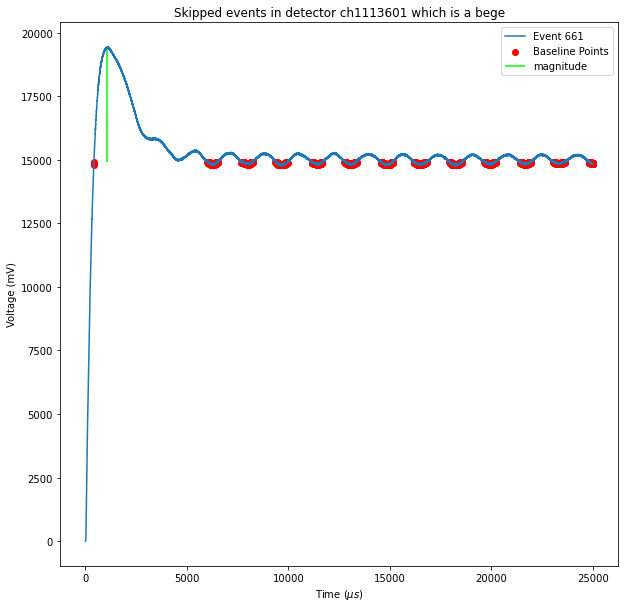

discharge


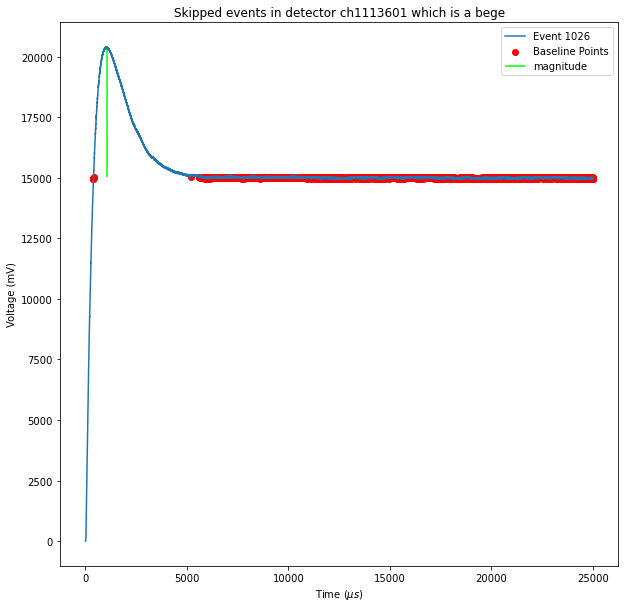

discharge


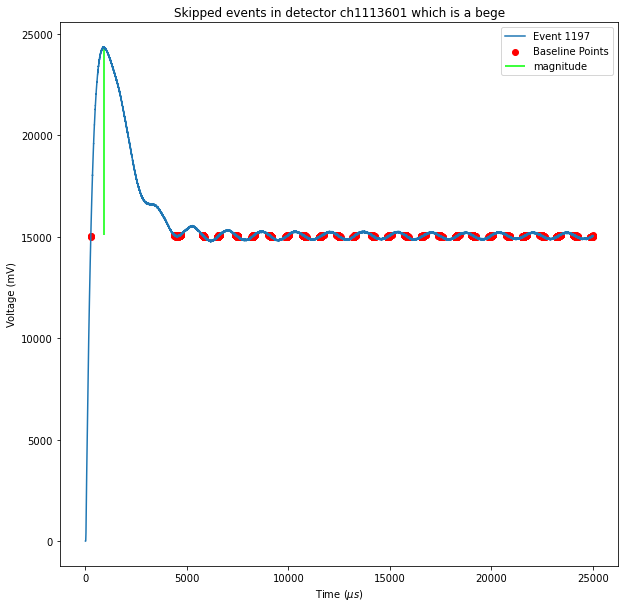

MESSY DISCHARGE


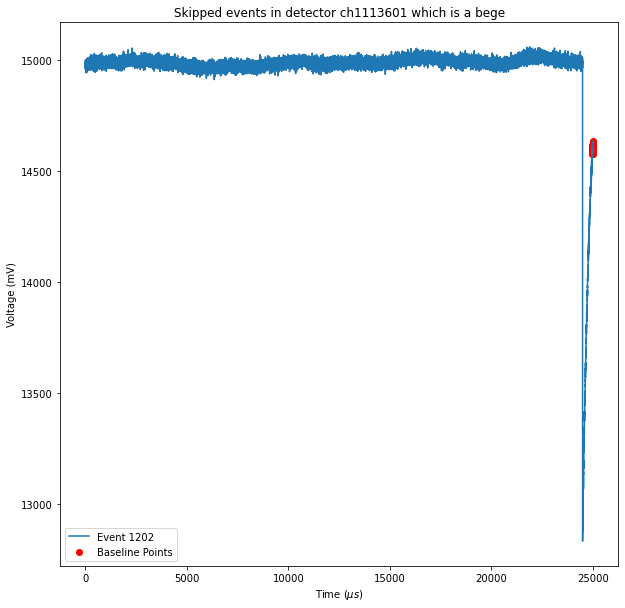

discharge


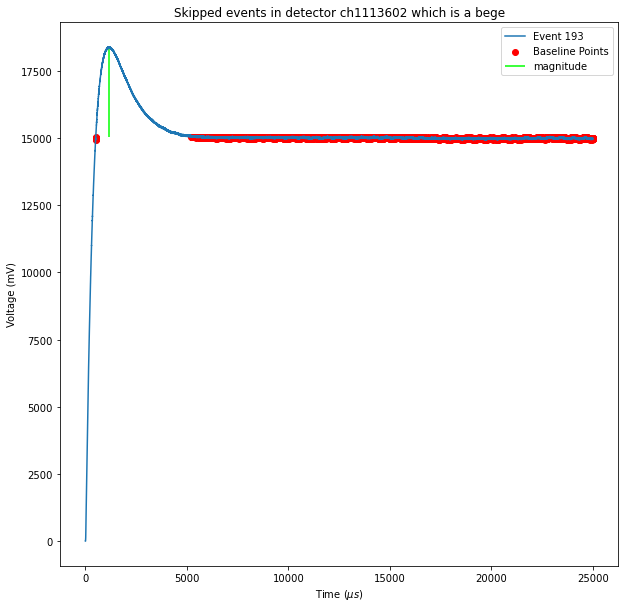

discharge


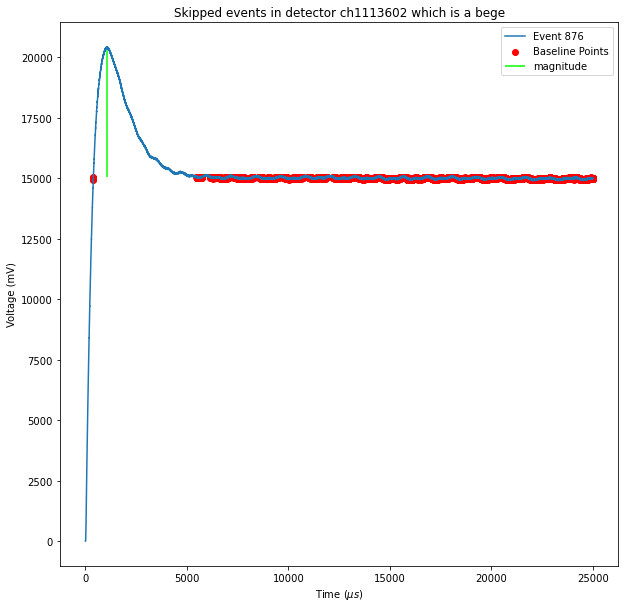

MESSY DISCHARGE


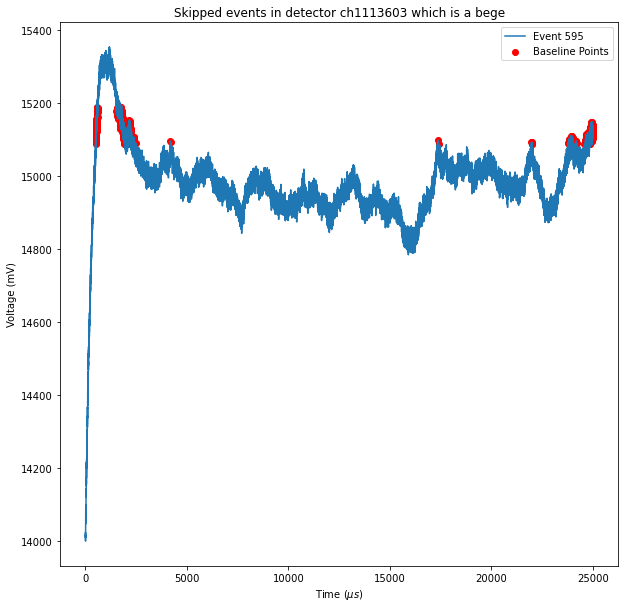

microdischarge


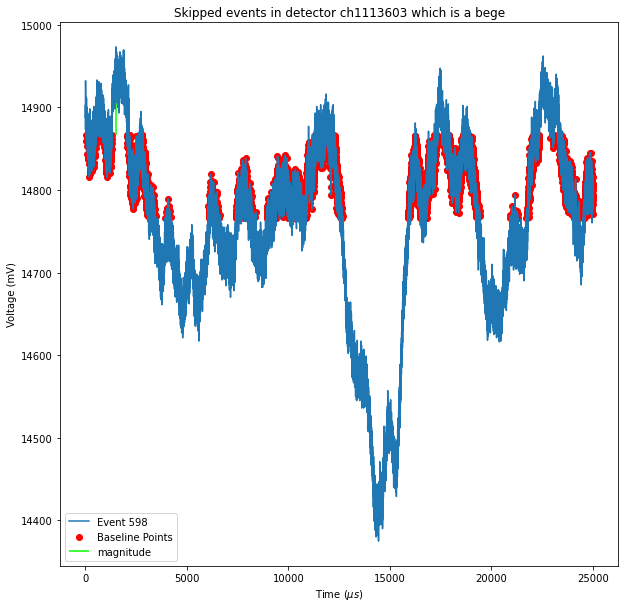

microdischarge


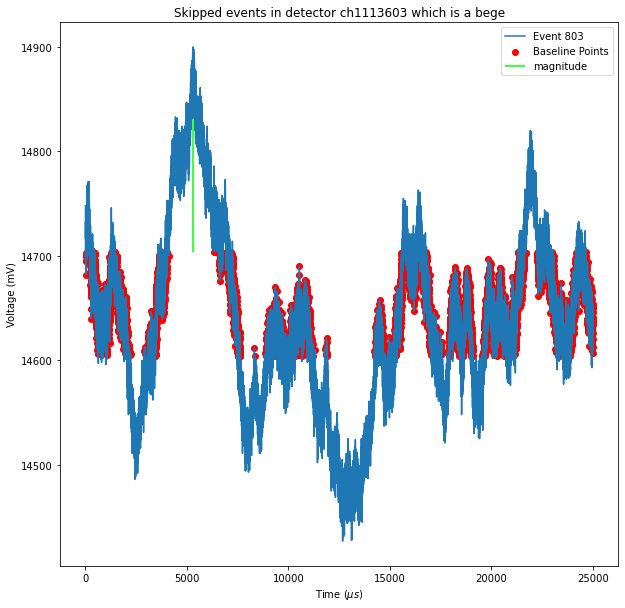

microdischarge


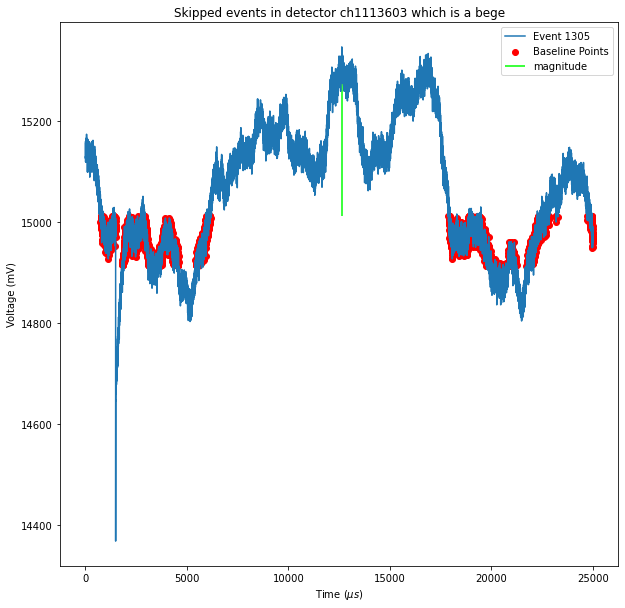

microdischarge


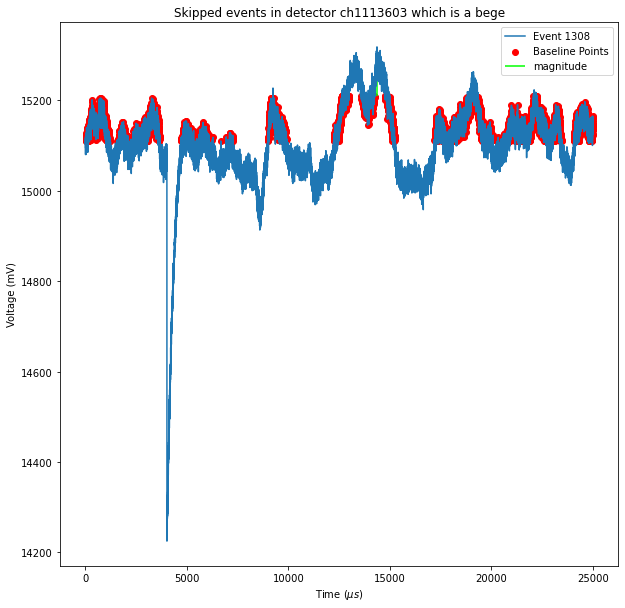

discharge


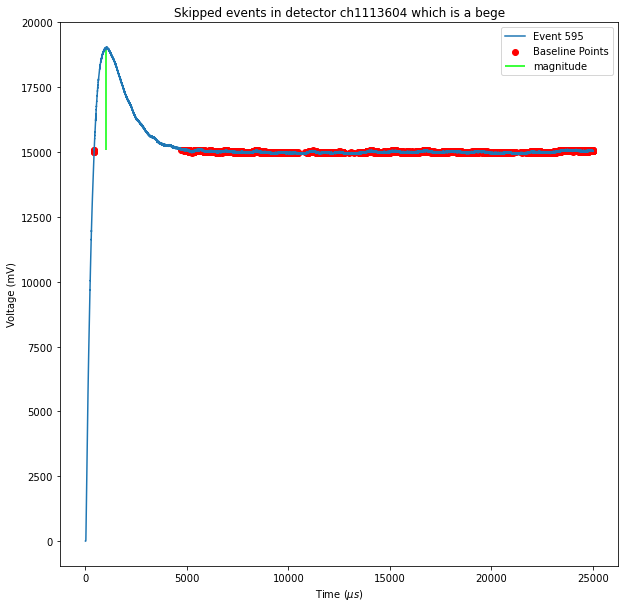

discharge


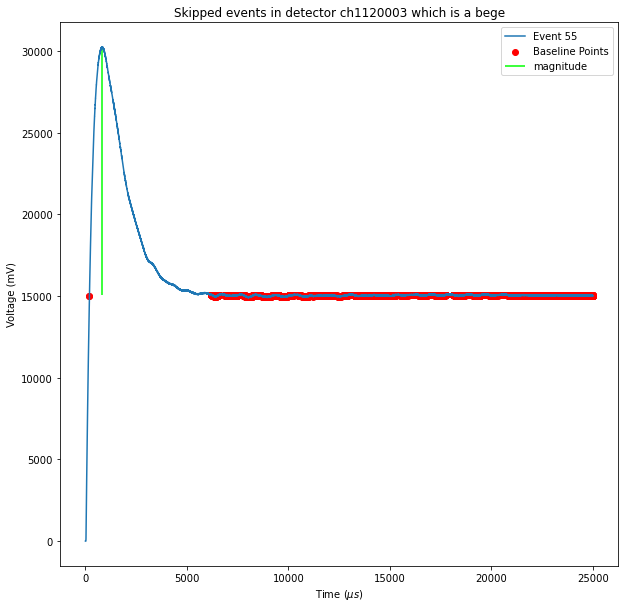

discharge


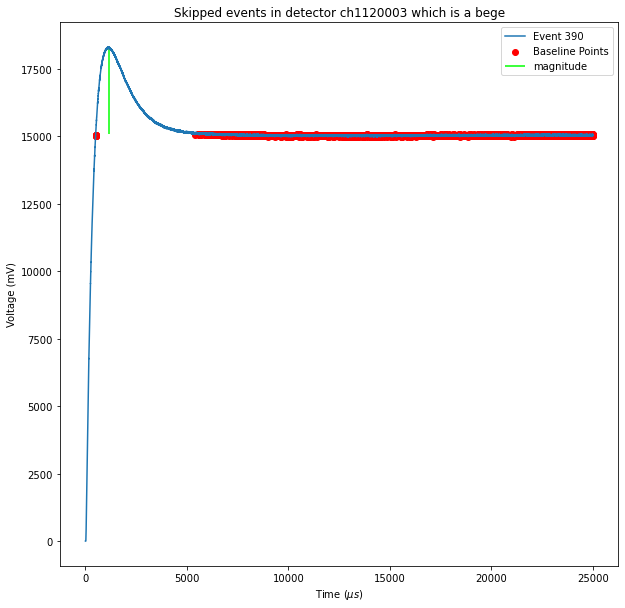

discharge


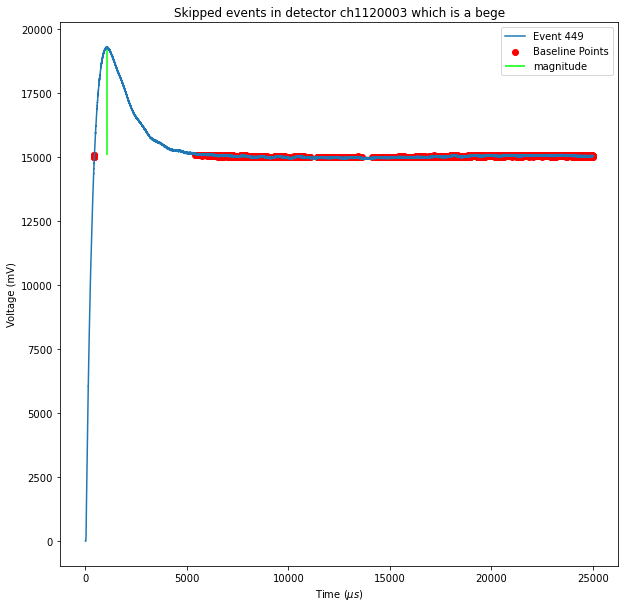

MESSY DISCHARGE


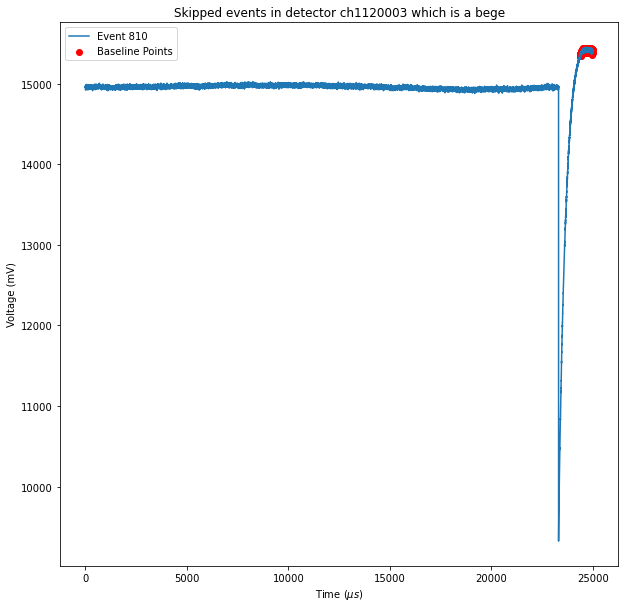

discharge


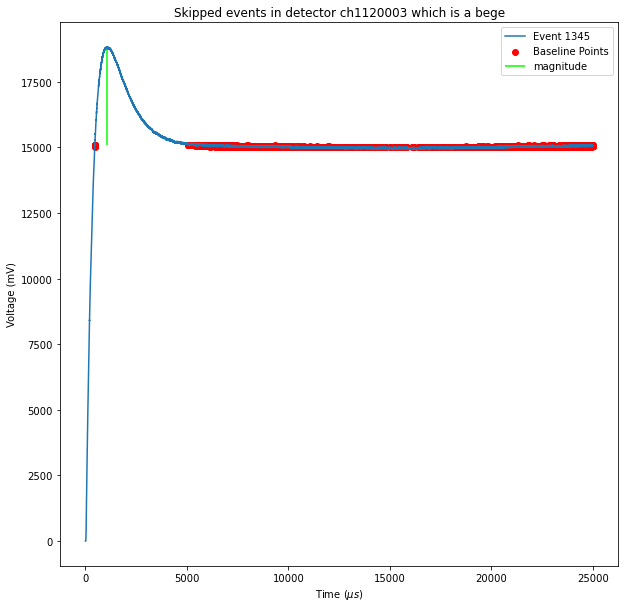

discharge


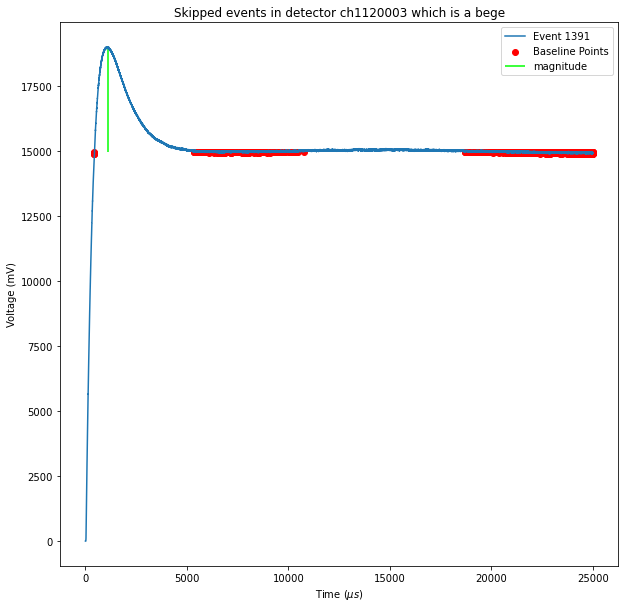

microdischarge


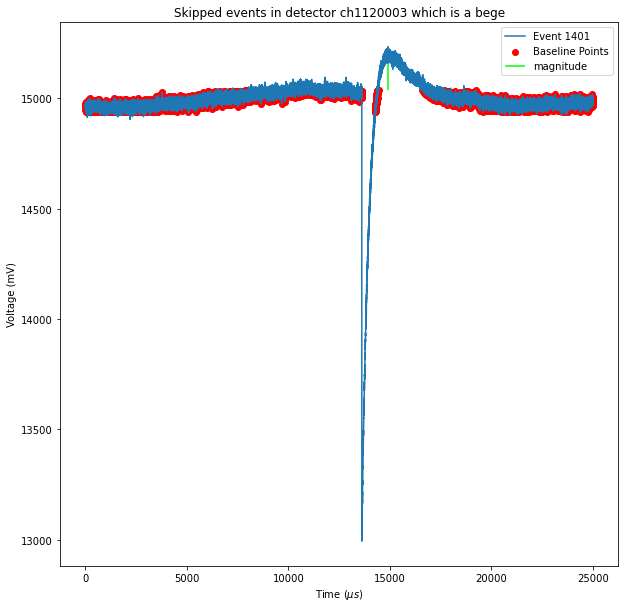

microdischarge


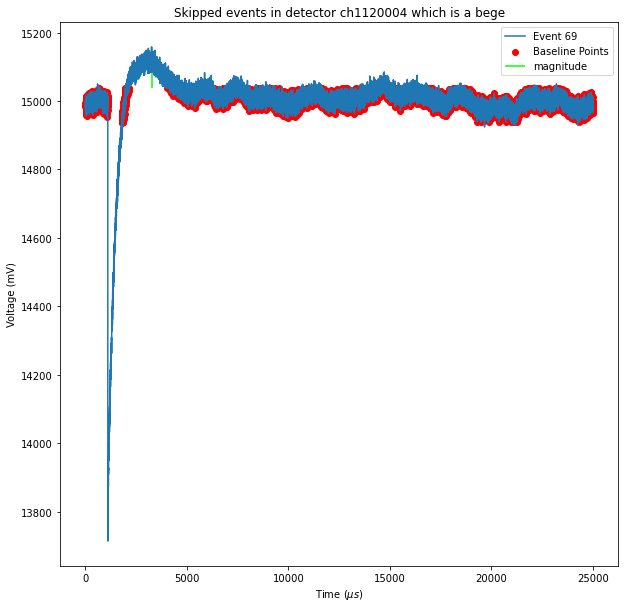

MESSY DISCHARGE


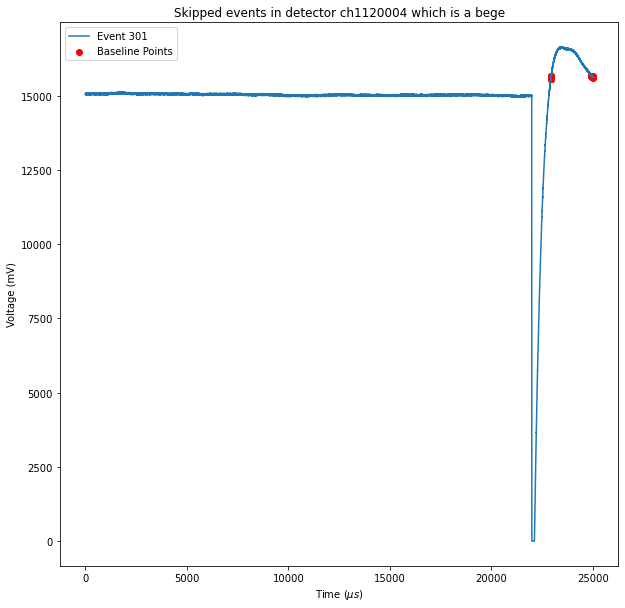

microdischarge


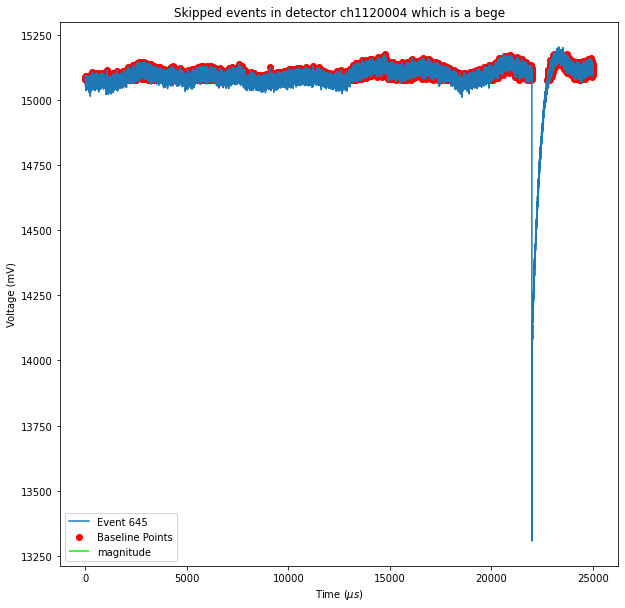

microdischarge


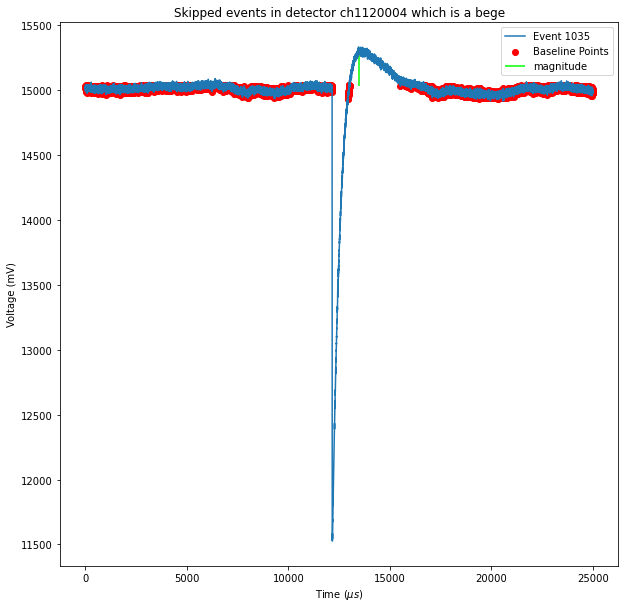

microdischarge


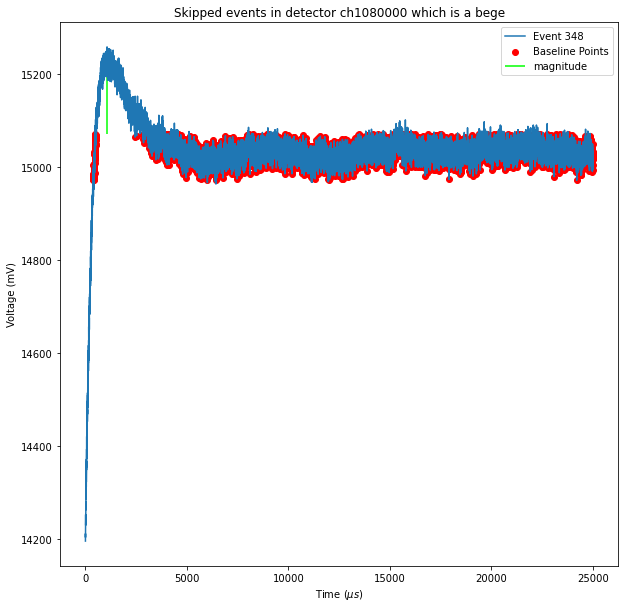

discharge


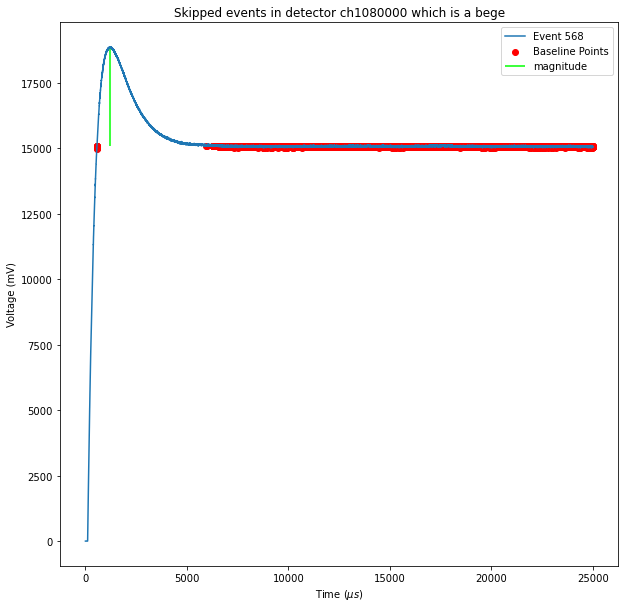

discharge


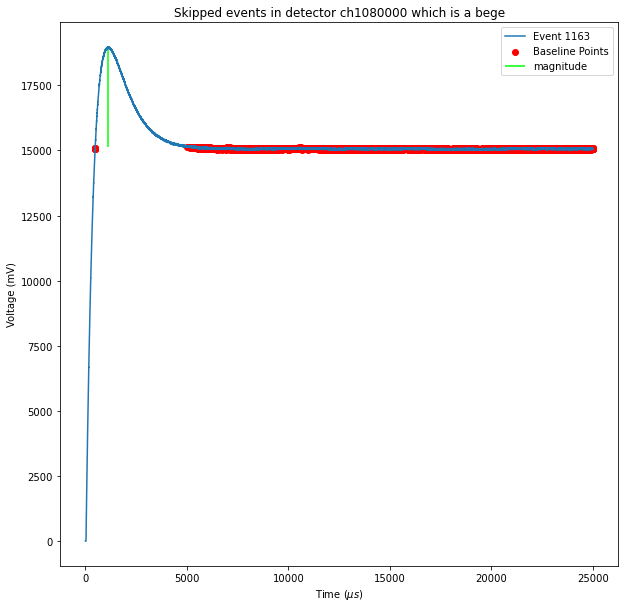

discharge


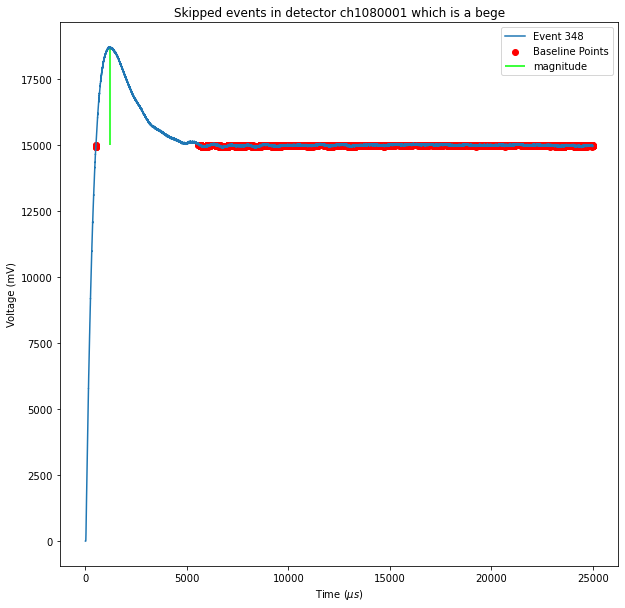

microdischarge


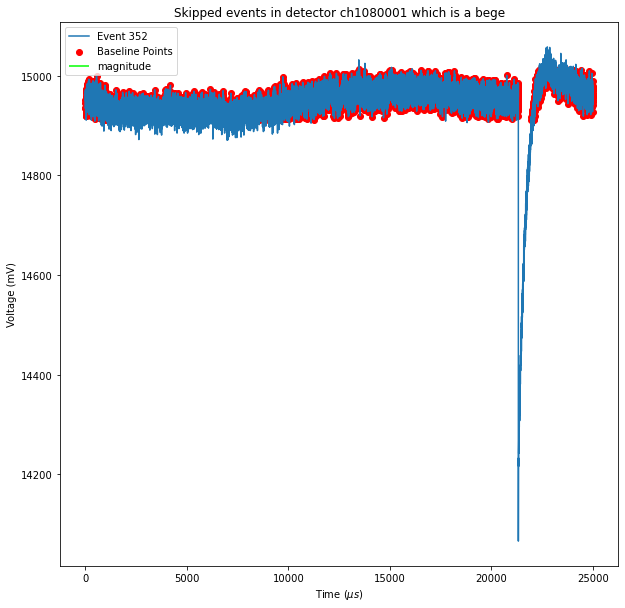

microdischarge


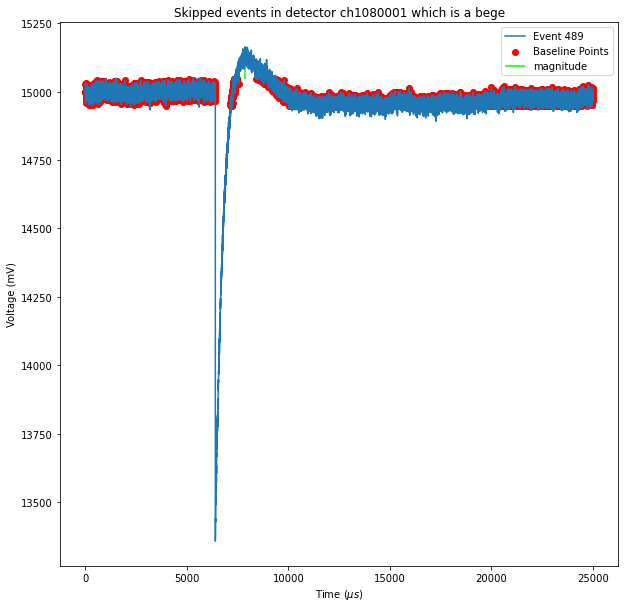

MESSY DISCHARGE


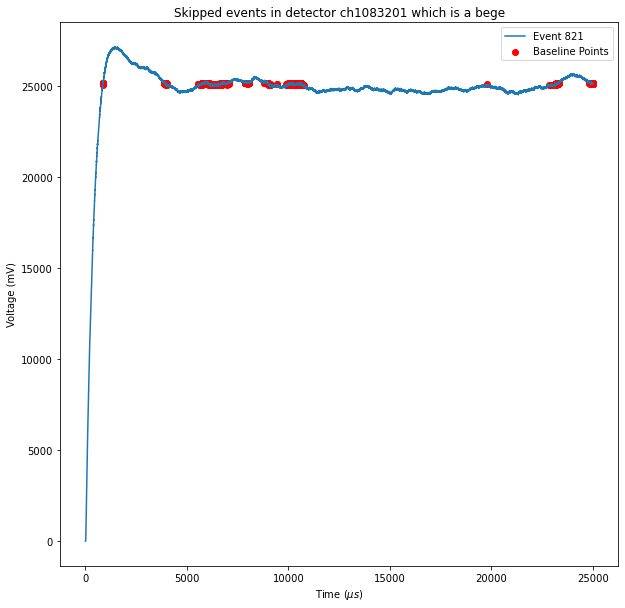

MESSY DISCHARGE


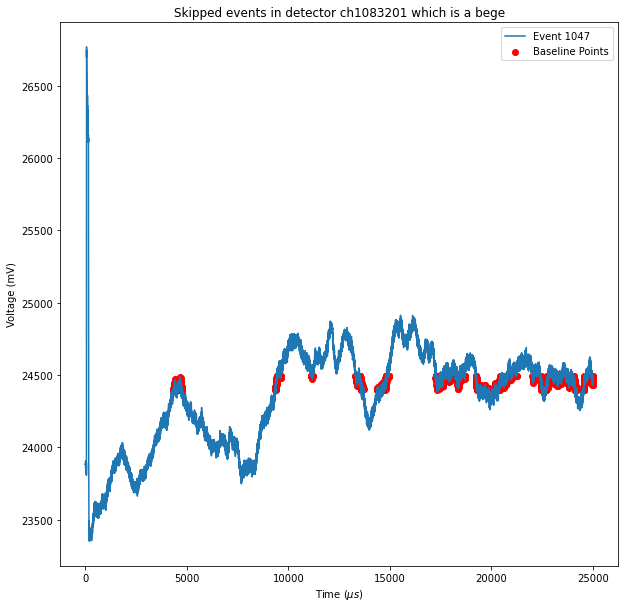

microdischarge


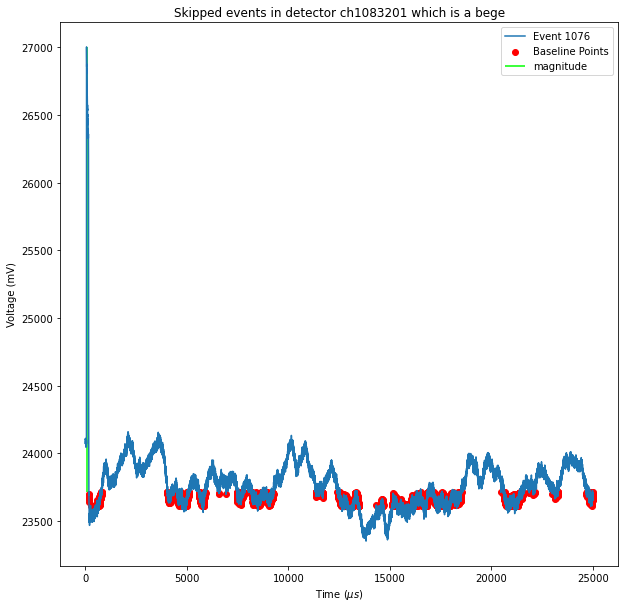

microdischarge


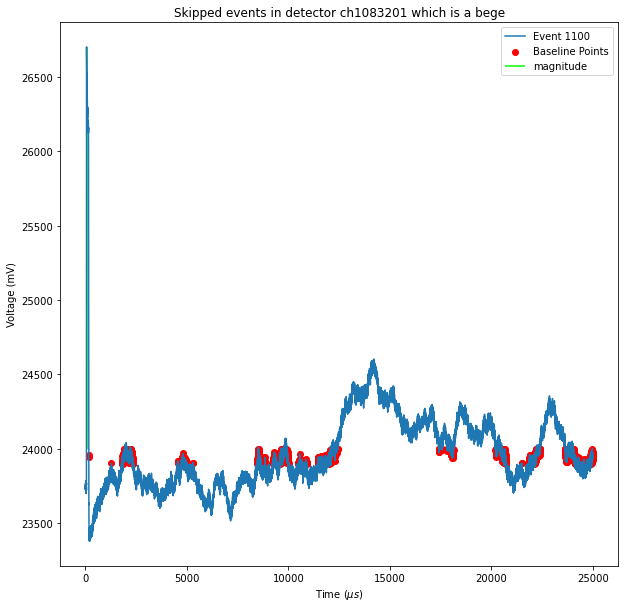

MESSY DISCHARGE


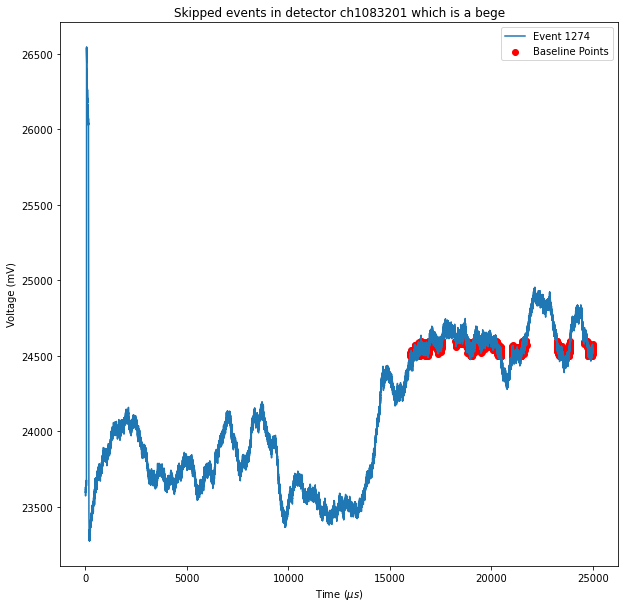

discharge


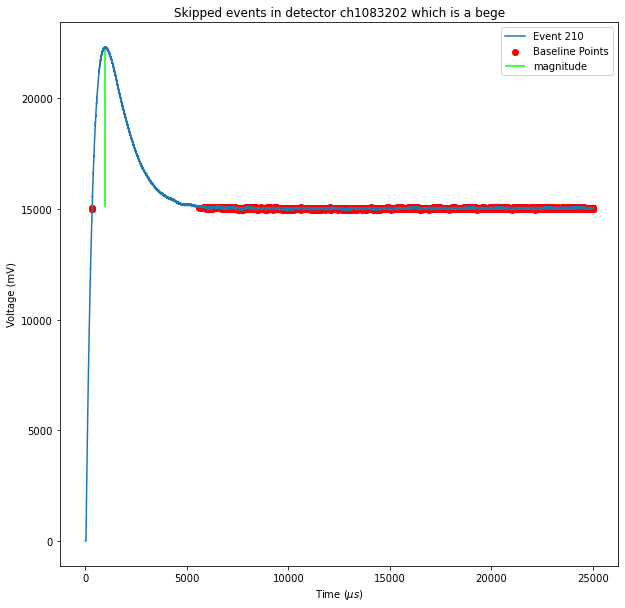

discharge


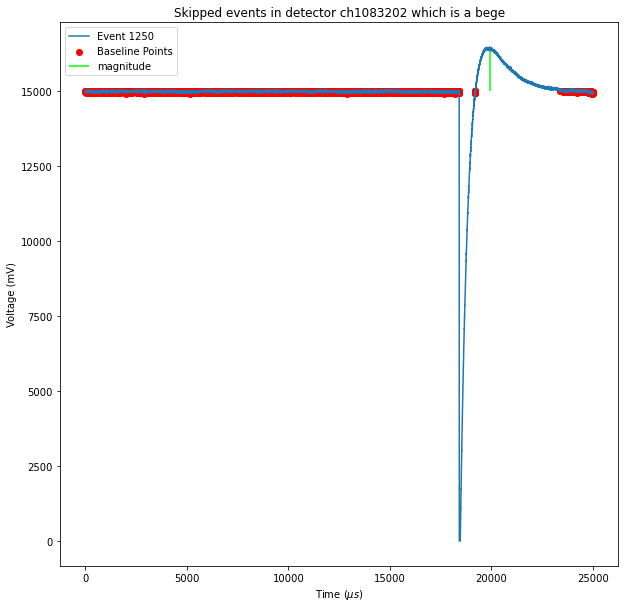

microdischarge


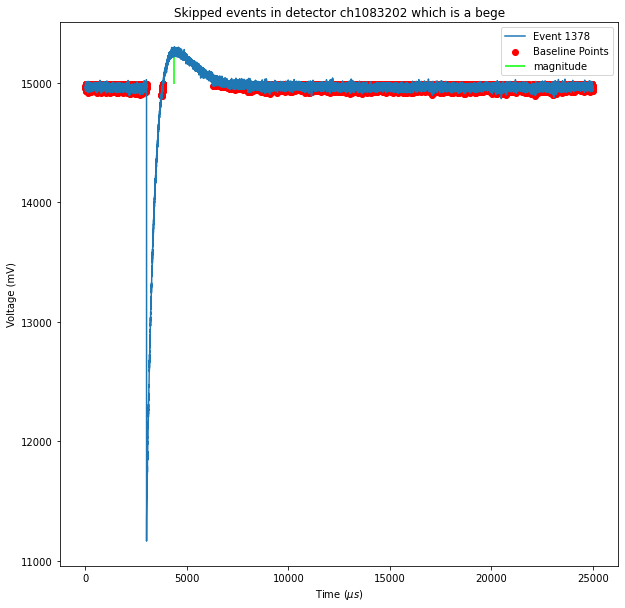

microdischarge


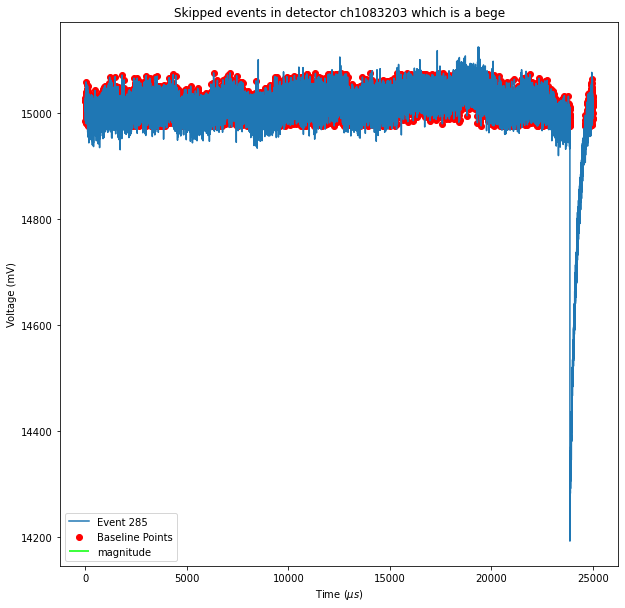

microdischarge


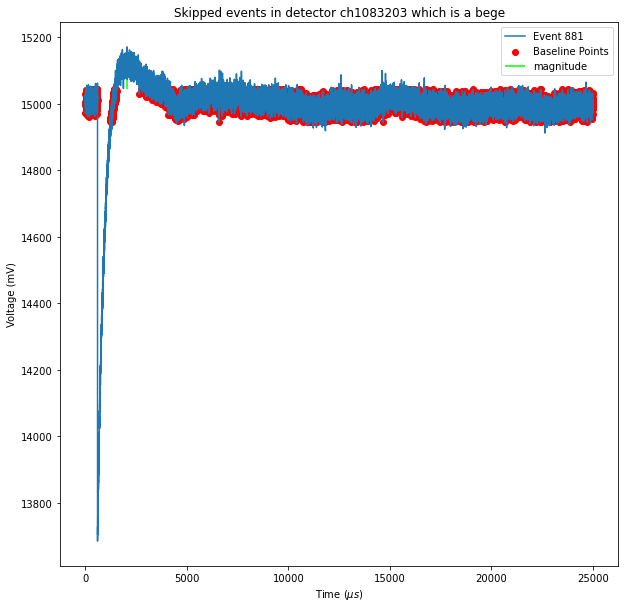

microdischarge


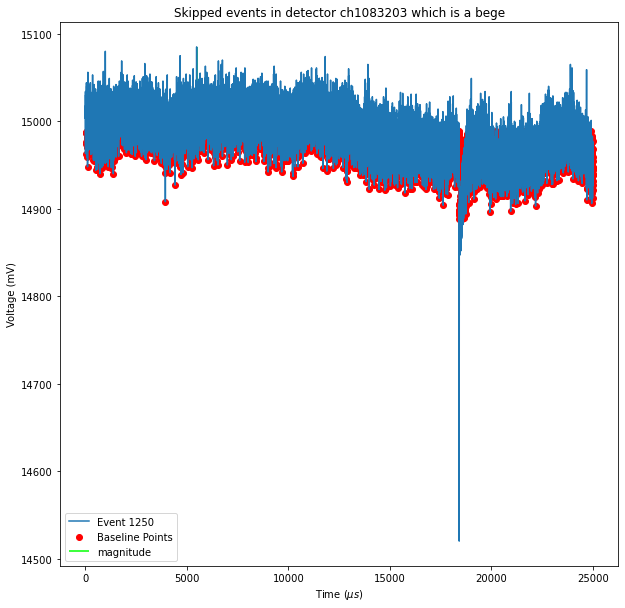

discharge


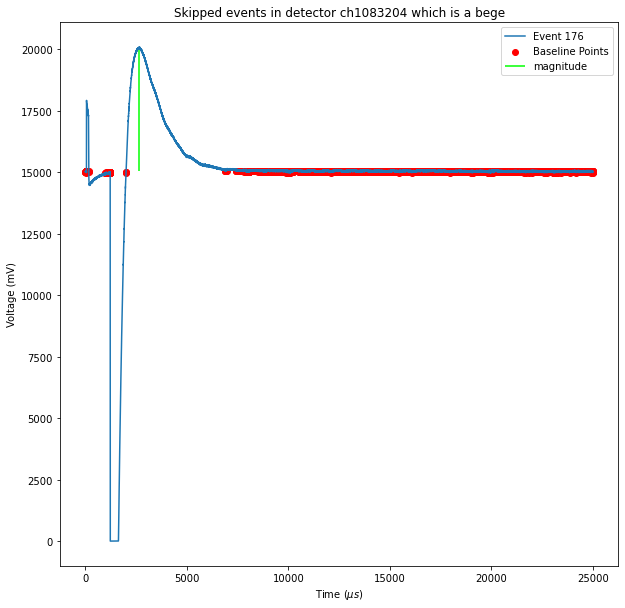

microdischarge


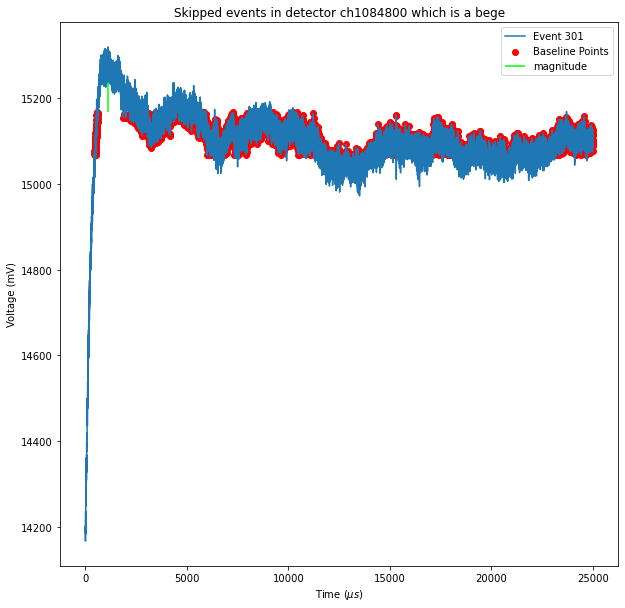

microdischarge


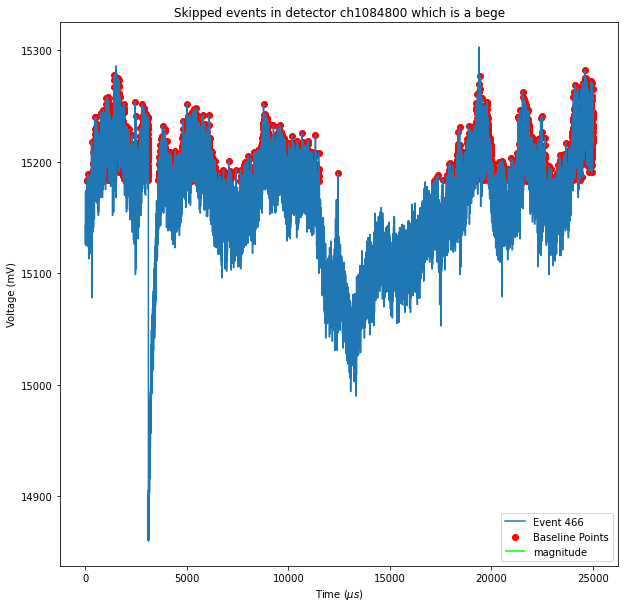

microdischarge


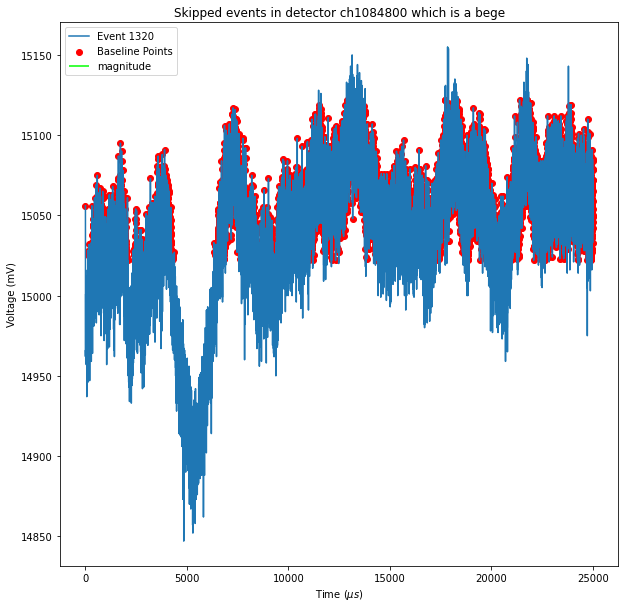

discharge


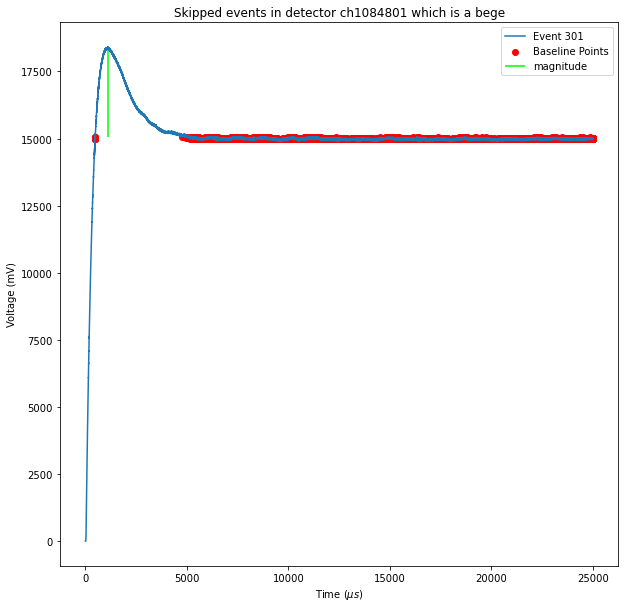

microdischarge


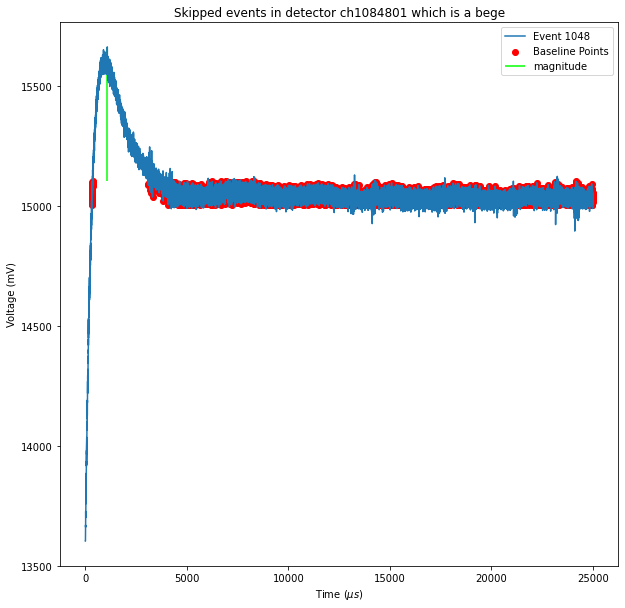

microdischarge


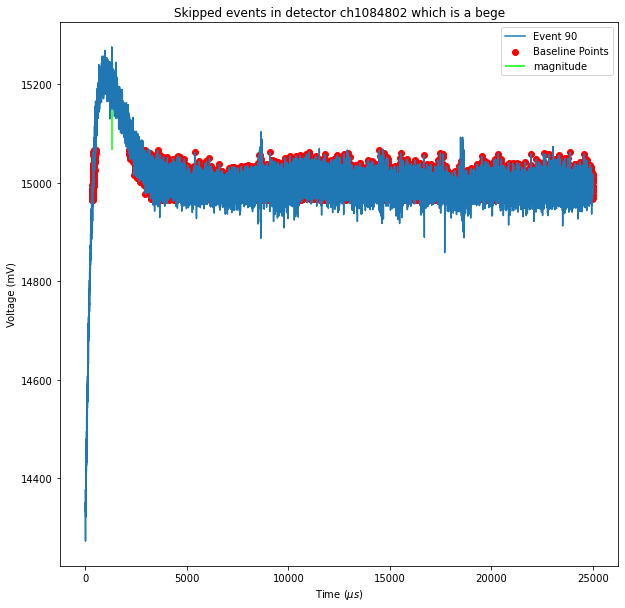

microdischarge


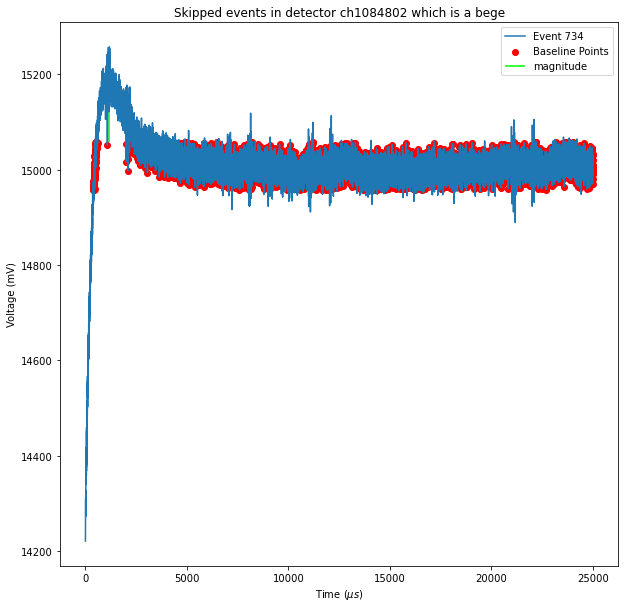

microdischarge


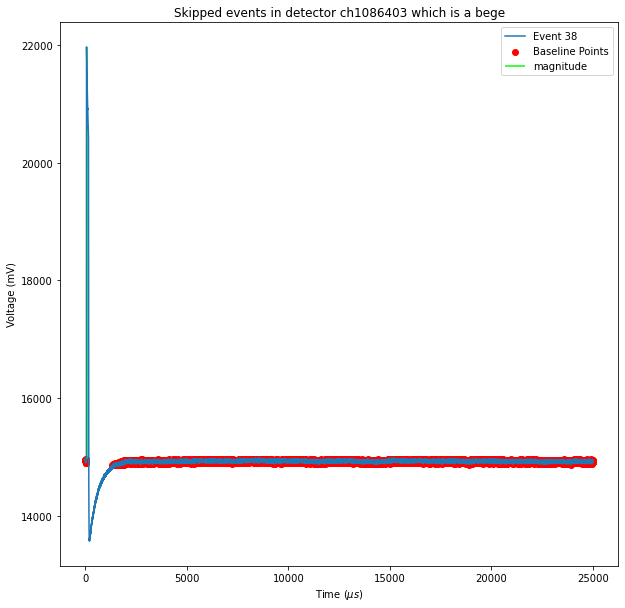

microdischarge


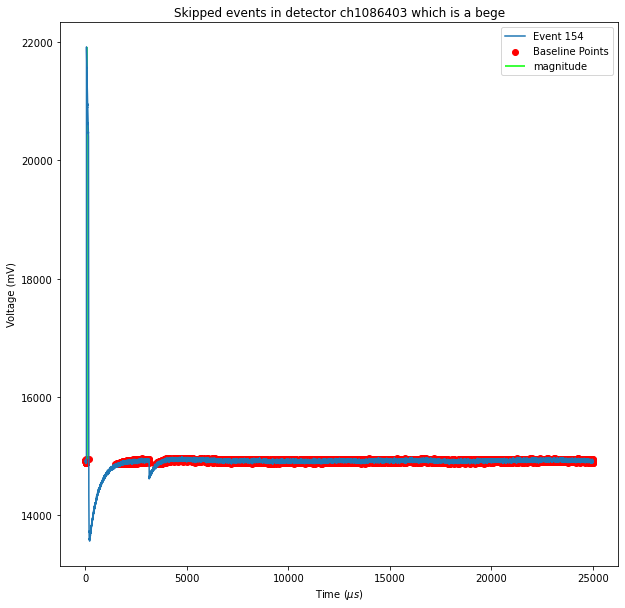

microdischarge


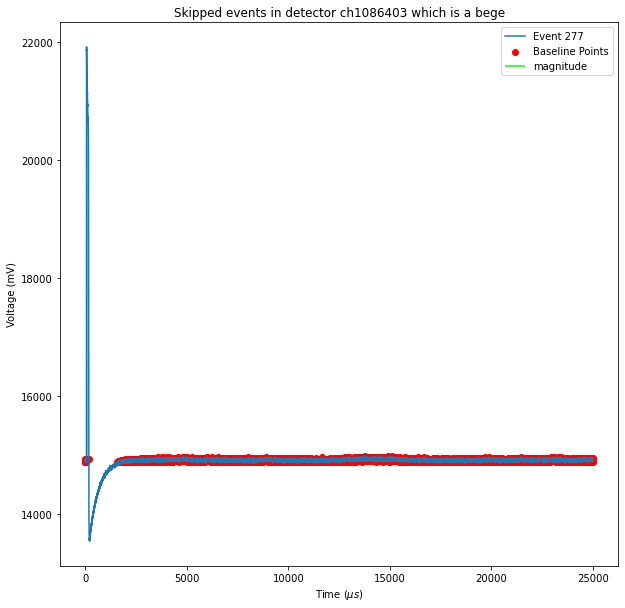

microdischarge


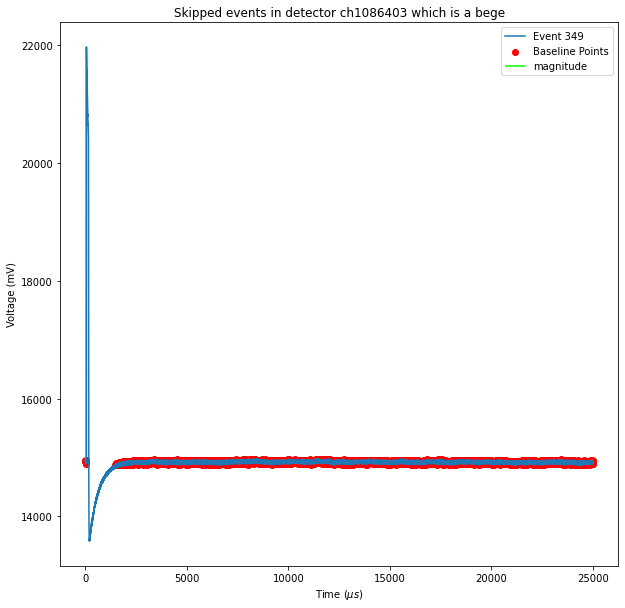

microdischarge


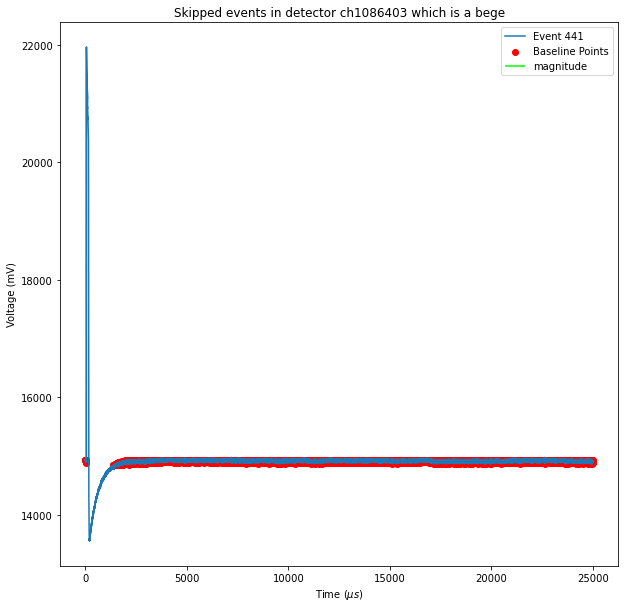

microdischarge


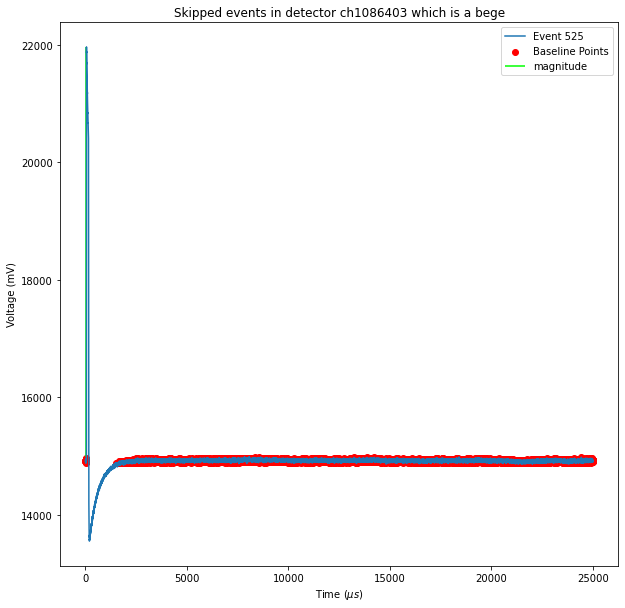

microdischarge


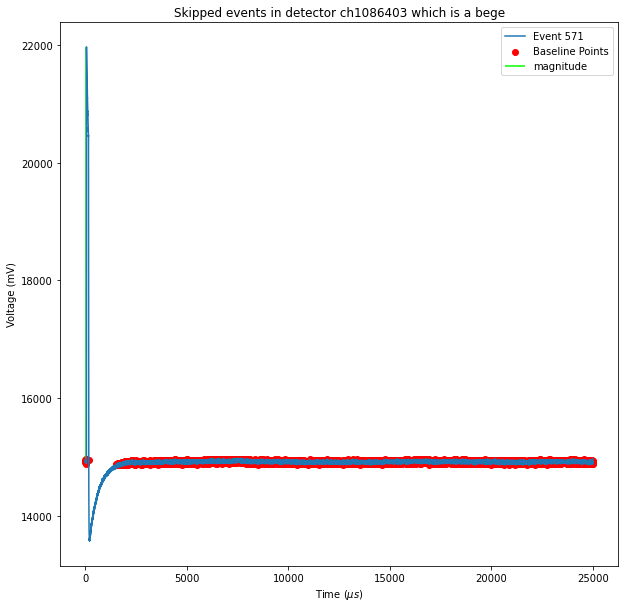

microdischarge


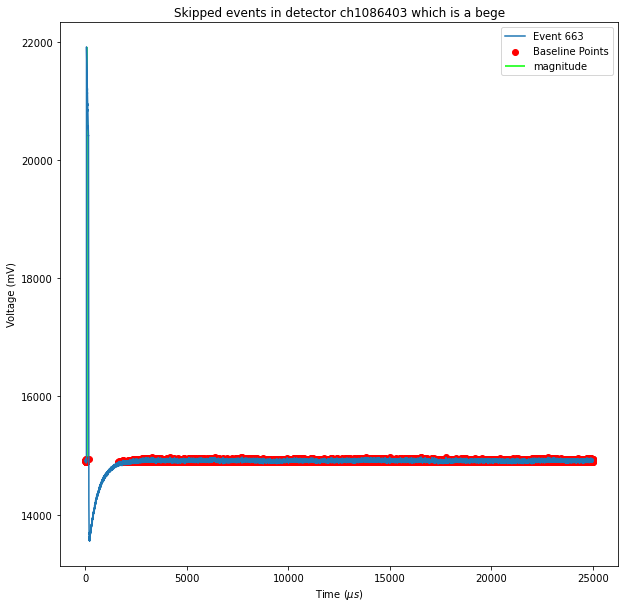

microdischarge


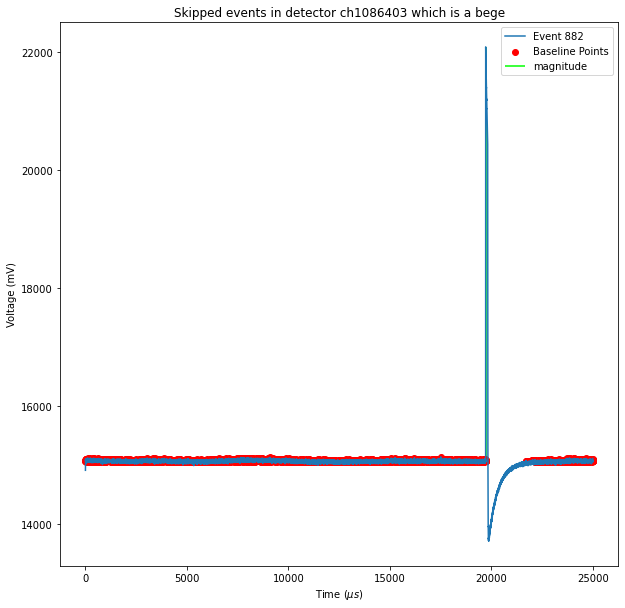

microdischarge


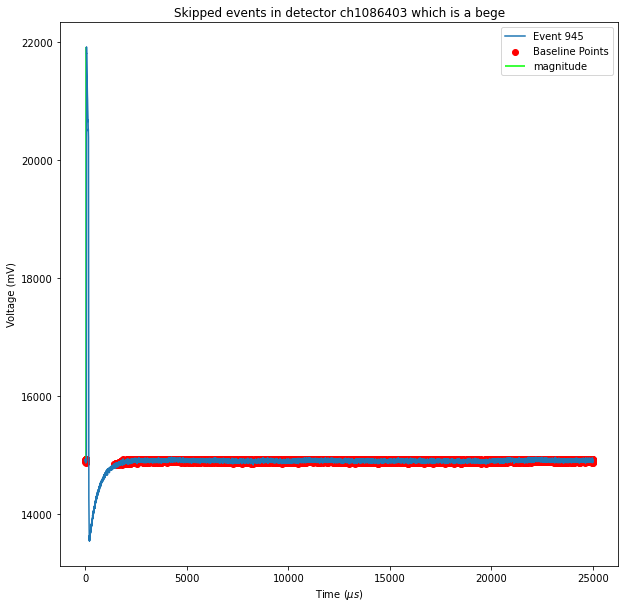

microdischarge


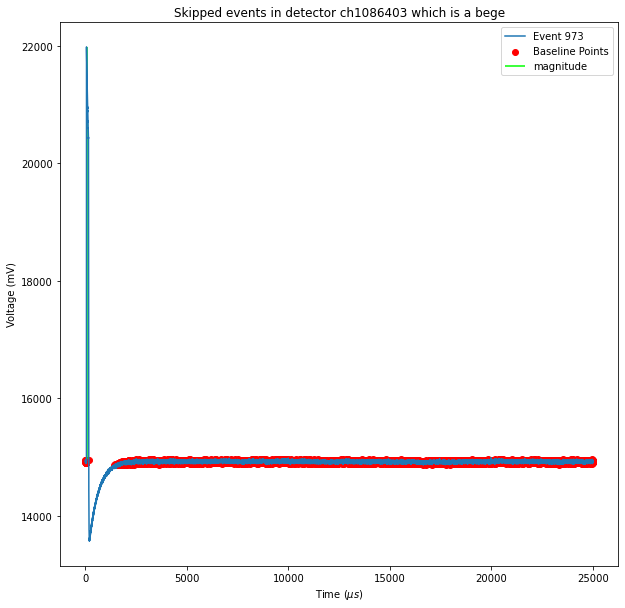

microdischarge


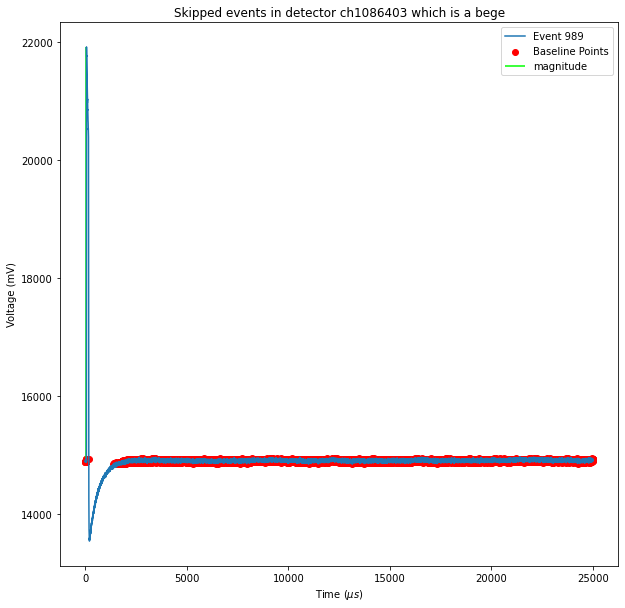

microdischarge


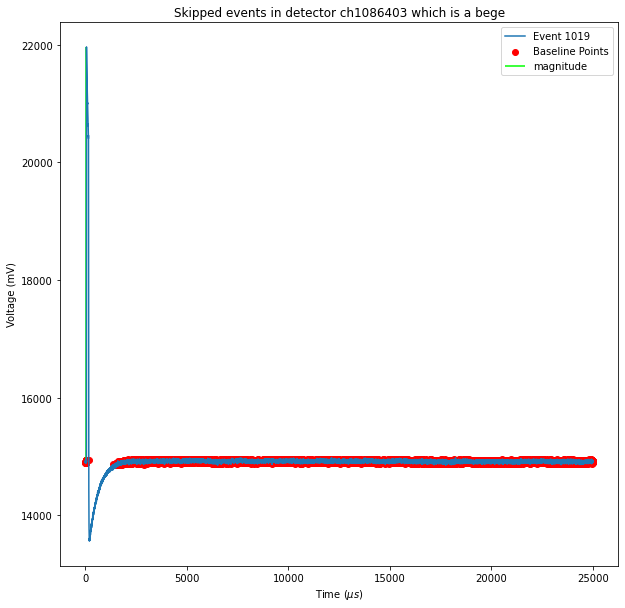

microdischarge


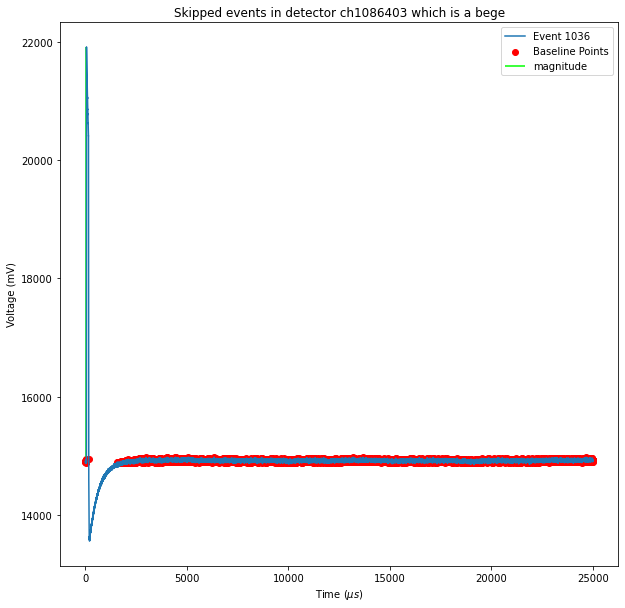

microdischarge


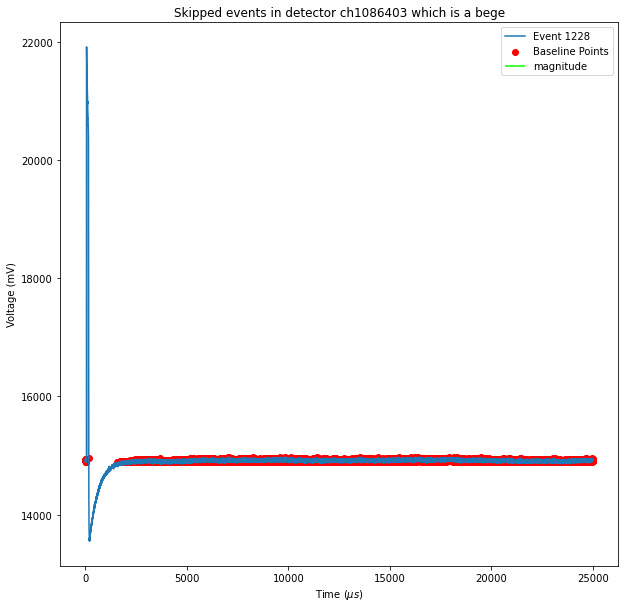

microdischarge


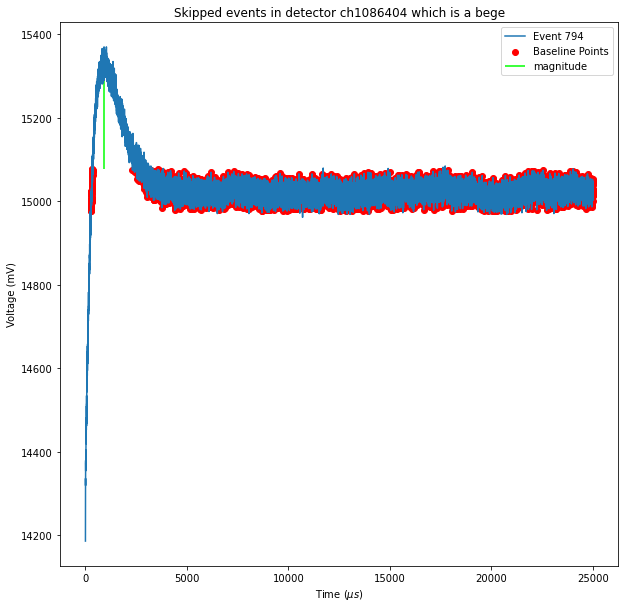

microdischarge


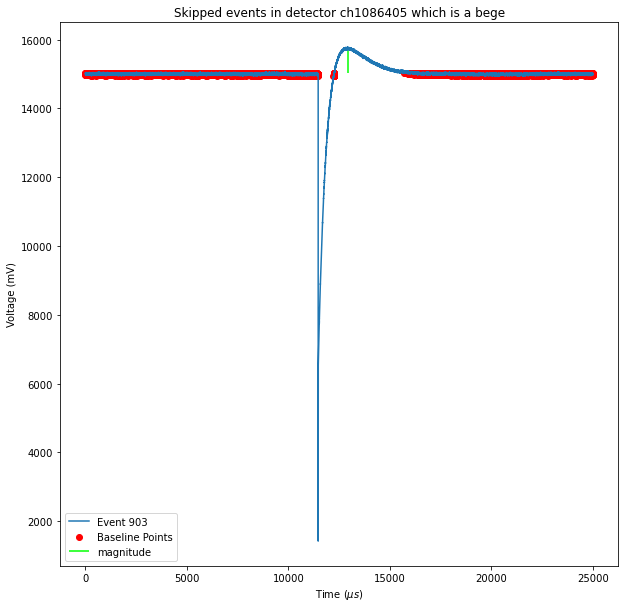

microdischarge


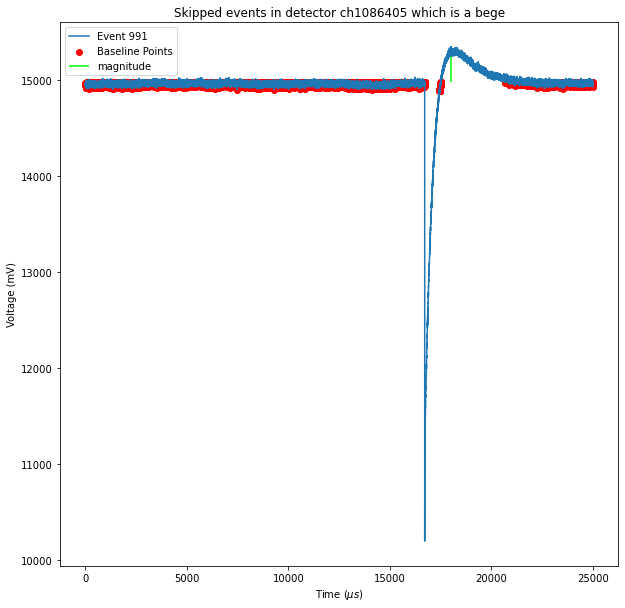

microdischarge


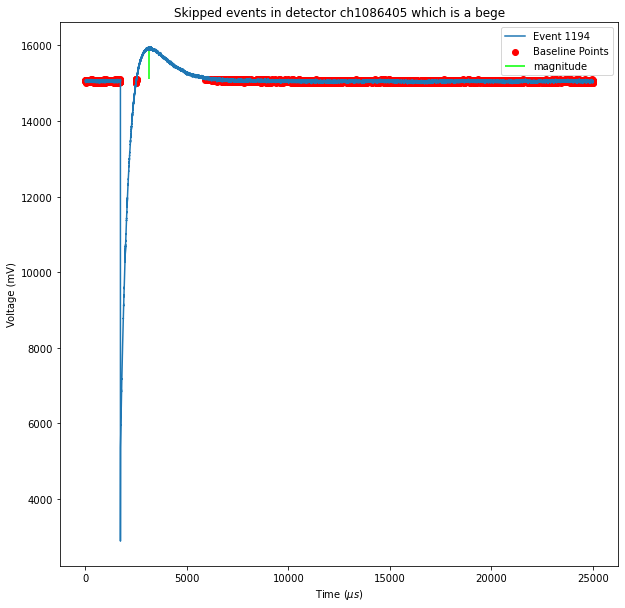

In [16]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event', 'Maximum magnitude','Minimum magnitude'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event', 'Maximum magnitude','Minimum magnitude'])

for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0)
            max_value = np.max(wf0) #maximum value in the waveform
            
            max_index = np.argmax(wf0) #index at which the maximum occurs at 
            time_of_max_value = ts[max_index] #x value of the maximum point
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
                
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}')  # plot each skipped waveform
            
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if weighted_average-51 < q < weighted_average+51:
                    for_x.append(t)
                    for_append.append(q)
                
                
            size = len(for_x)
            plt.scatter(for_x, for_append, color='r', label='Baseline Points')
            #differences between subsequent baseline points 
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0: #if there are differences between baseline points there is some instabilkity 
                if size>4000: #if there are fewer than 4000 baseline points then there is no clear baseline
                    top_val = max_value - weighted_average +51 #the smallest possible magnitude 
                    bot_val = max_value - weighted_average -51 #the largest possible magnitude 
                    plt.vlines(x = time_of_max_value, ymin = weighted_average+50, ymax =max_value,colors = 'lime',label = 'magnitude')
                    
                    if np.any(wf0[:]==0):
                        discharge_type = "discharge"
                        print("discharge")
                        df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Minimum magnitude': bot_val,
                        'Maximum magnitude': top_val,
                    }, ignore_index=True)
                    else:
                        discharge_type = "microdischarge"
                        print("microdischarge")
                        df1 = df1.append({
                            'Detector Name': j,
                            'Event':i,
                            'Type': discharge_type,
                            'Minimum magnitude': bot_val,
                            'Maximum magnitude': top_val,
                        }, ignore_index=True)
                else:
                    print("MESSY DISCHARGE")
            else:
                print("NO DISCHARGE")
                
                
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [17]:
#extracting the data frames to an excel file

excel_filename = 'magnitude_discharge_bege.xlsx'
df.to_excel(excel_filename, index=False)
excel_filename = 'magnitude_microdischarge_bege.xlsx'
df1.to_excel(excel_filename, index=False)